In [452]:
!pip install pyspark
!pip install prophet
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [453]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType ,desc
from pyspark.sql.types import *
from pyspark.sql import functions as f
from prophet import Prophet
import matplotlib
import matplotlib.pyplot as plt

In [454]:
spark = SparkSession.builder\
    .master("local")\
    .appName("Colab")\
    .config('spark.ui.port', '4050')\
    .getOrCreate()
spark

In [455]:
from pyspark.sql.functions import col,lit, avg
attend = spark.read.option("header",True).csv("/content/AE_attendances.csv", inferSchema=True)

attend = attend.select(col("date").alias("ds"), col("Name"), col("Total attendances").alias("y"))

In [456]:
attend = attend.filter(f.col("y") != 0).na.drop()

In [457]:
def filter_top_names(df):
    counts = df.groupBy('Name').count()

    max_count = counts.agg({'count': 'max'}).collect()[0][0]
    top_names = counts.filter(counts['count'] == max_count).select('Name')

    filtered_df = df.join(top_names, 'Name', 'inner')

    return filtered_df

attend = filter_top_names(attend)

In [458]:
attend = attend.filter(~f.col("Name").isin(['County Durham And Darlington NHS Foundation Trust', 'South Tyneside NHS Foundation Trust', 'Liverpool Community Health NHS Trust', 'Royal Liverpool And Broadgreen University Hospitals NHS Trust', 'Central Manchester University Hospitals NHS Foundation Trust', 'Gateshead Health NHS Foundation Trust', 'Salford Royal NHS Foundation Trust', 'Southport And Ormskirk Hospital NHS Trust', 'St Helens And Knowsley Hospitals NHS Trust', 'Wirral University Teaching Hospital NHS Foundation Trust', 'Harrogate And District NHS Foundation Trust', 'University Hospitals Of Leicester NHS Trust', 'George Eliot Hospital NHS Trust', 'Bedford Hospital NHS Trust', 'Cambridge University Hospitals NHS Foundation Trust', 'Southend University Hospital NHS Foundation Trust', 'Homerton University Hospital NHS Foundation Trust', 'Royal Surrey County Hospital NHS Foundation Trust', 'Surrey And Sussex Healthcare NHS Trust', 'Great Western Hospitals NHS Foundation Trust', 'Northern Devon Healthcare NHS Trust', 'South Tees Hospitals NHS Foundation Trust', 'Countess Of Chester Hospital NHS Foundation Trust']))

In [459]:
#attend.show()

In [460]:
#attend.filter(f.col("Name") == 'City Hospitals Sunderland NHS Foundation Trust').describe().show()#.toPandas().to_csv('desc.csv')

In [461]:
#attend.describe().show()

In [462]:
from pyspark.sql.functions import stddev, mean
scatter = attend.groupby('Name').agg( mean('y'), stddev('y'))

In [463]:
#scatter.describe().show()

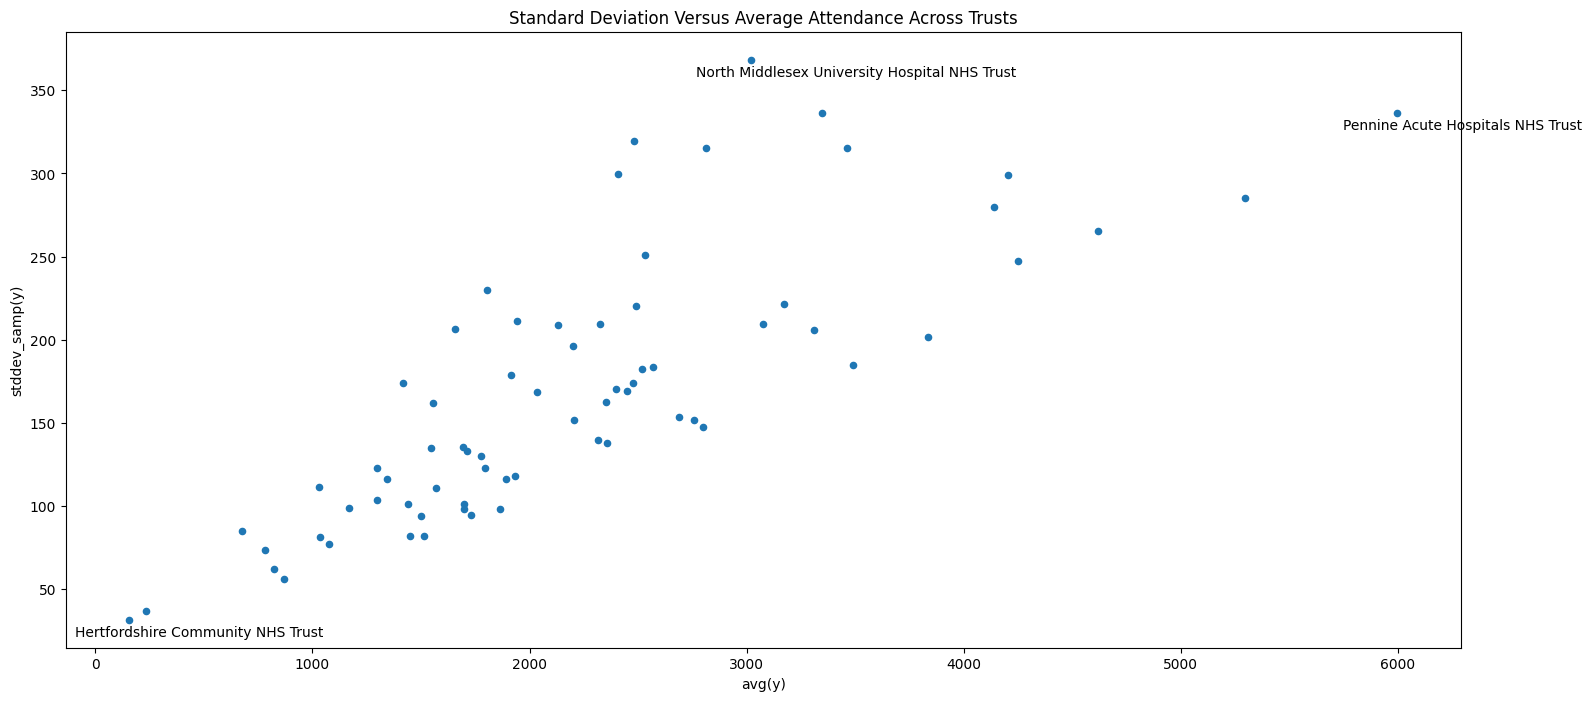

In [464]:
fig, ax = plt.subplots()
scatter_p = scatter.toPandas()
for i, row in scatter_p.iterrows():
    if row.Name not in ['North Middlesex University Hospital NHS Trust', 'Pennine Acute Hospitals NHS Trust', 'Hertfordshire Community NHS Trust']:
        scatter_p.loc[i, 'Name'] = ''
scatter_p = scatter_p.set_index('Name')
scatter_p.plot( y='stddev_samp(y)',  x='avg(y)',kind='scatter', figsize= (18,8), title='Standard Deviation Versus Average Attendance Across Trusts' , ax=ax)
for k, v in scatter_p.iterrows():
    ax.annotate(k, (v[0]-250,v[1]-10))

In [465]:
## Uncomment this to include model for total attendaces accross all trusts
# from pyspark.sql.types import DateType
# total_week = attend.groupby('ds').sum("y").withColumn("Name", lit('Total')).select(col("ds"), col("Name"), col("sum(y)").alias("y"))
# total_week = total_week.withColumn("ds",f.to_date(f.col('ds'), 'dd/MM/yyyy'))
# total_week= total_week.withColumn("y", col("y").cast('int'))

# attend = attend.withColumn("ds",f.to_date(f.col('ds'), 'dd/MM/yyyy'))
# attend= attend.withColumn("y", col("y").cast('int'))

# attend = attend.unionByName(total_week)

In [466]:
attend.printSchema()

root
 |-- Name: string (nullable = true)
 |-- ds: date (nullable = true)
 |-- y: double (nullable = true)



In [467]:
from pyspark.sql.functions import countDistinct
attend.agg(countDistinct("Name")).show()

+-----------+
|count(Name)|
+-----------+
|         70|
+-----------+



In [468]:
attend.head(20)

[Row(Name='City Hospitals Sunderland NHS Foundation Trust', ds=datetime.date(2011, 4, 10), y=2389.0),
 Row(Name='North Tees And Hartlepool NHS Foundation Trust', ds=datetime.date(2011, 4, 10), y=2158.0),
 Row(Name='Northumbria Healthcare NHS Foundation Trust', ds=datetime.date(2011, 4, 10), y=3452.0),
 Row(Name='The Newcastle Upon Tyne Hospitals NHS Foundation Trust', ds=datetime.date(2011, 4, 10), y=3245.0),
 Row(Name='East Cheshire NHS Trust', ds=datetime.date(2011, 4, 10), y=1102.0),
 Row(Name='East Lancashire Hospitals NHS Trust', ds=datetime.date(2011, 4, 10), y=3877.0),
 Row(Name='Lancashire Teaching Hospitals NHS Foundation Trust', ds=datetime.date(2011, 4, 10), y=2496.0),
 Row(Name='Mid Cheshire Hospitals NHS Foundation Trust', ds=datetime.date(2011, 4, 10), y=1540.0),
 Row(Name='Pennine Acute Hospitals NHS Trust', ds=datetime.date(2011, 4, 10), y=6697.0),
 Row(Name='Stockport NHS Foundation Trust', ds=datetime.date(2011, 4, 10), y=1842.0),
 Row(Name='Tameside Hospital NHS Foun

Train Test Split

In [469]:
date_split = '2014-06-29 00:00:00'
attend_train = attend.filter(f.col("ds") < f.unix_timestamp(f.lit(date_split)).cast('timestamp'))
attend_test = attend.filter(f.col("ds") >= f.unix_timestamp(f.lit(date_split)).cast('timestamp'))

#attend_train = attend_train.select(col("ds"), col("Name"), col("y").alias("y_train"))
#attend_test = attend_test.select(col("ds"), col("Name"), col("y").alias("y_test"))

In [470]:
attend_train_pd = attend_train.toPandas()
attend_test_pd = attend_test.toPandas()

In [471]:
def plot_train_test(Name):
    attend_train_plot = attend_train_pd[attend_train_pd['Name'] == Name]
    attend_test_plot = attend_test_pd[attend_test_pd['Name']== Name]
    attend_train_plot = attend_train_plot[['y', 'ds']].set_index('ds')
    attend_test_plot = attend_test_plot[['y', 'ds']].set_index('ds')
    attend_test_plot.rename(columns={'y':'Test'}).join(attend_train_plot.rename(columns={'y':'Train'}), how= 'outer').plot(figsize= (18,8))
    plt.ylabel('Num. Attendances')
    plt.title(Name)
    plt.show()
    #plt.savefig('/content/Train_Test_Pics/' + Name +'.png')
    #print(name)

# names = attend_train_pd.Name.unique()
# for name in names:
#     plot_train_test(name)


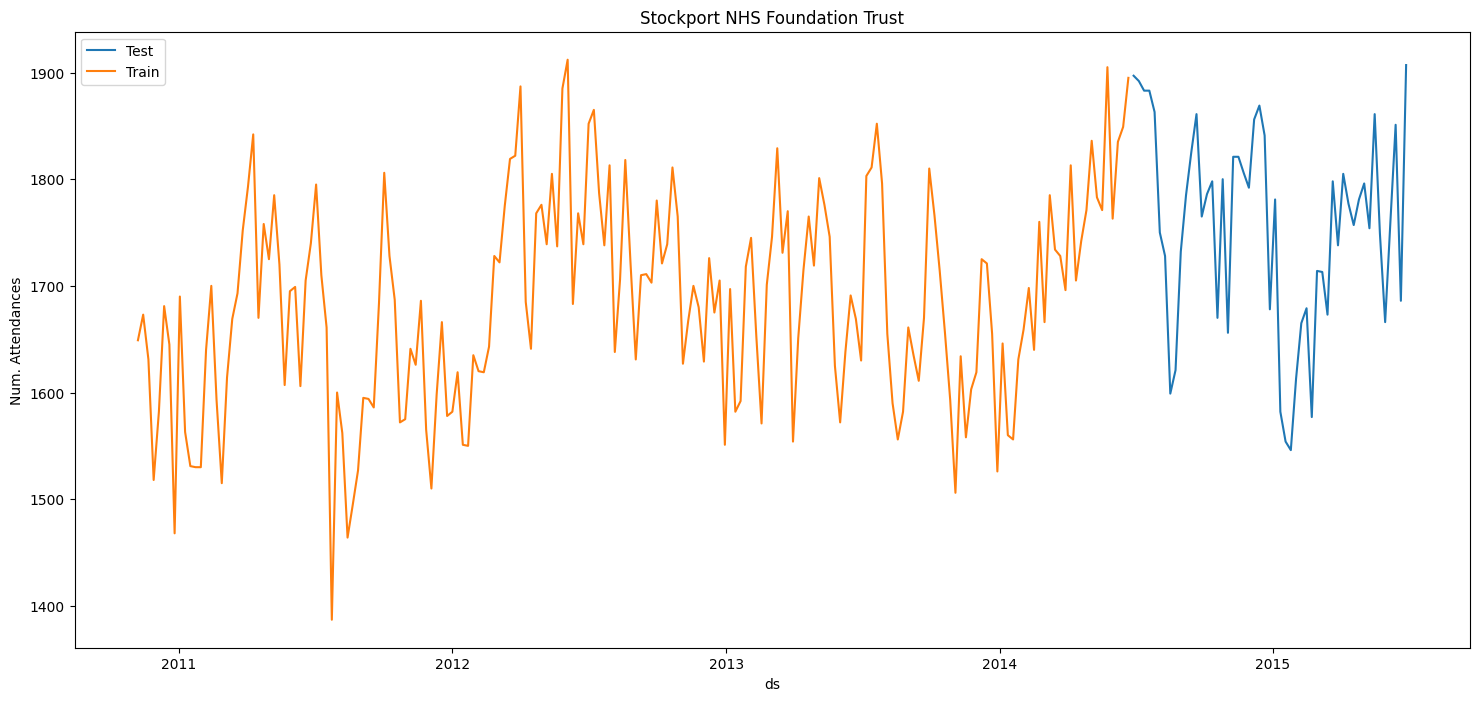

In [472]:
plot_train_test('Stockport NHS Foundation Trust')

In [473]:
# Partition the data
attend_train.createOrReplaceTempView("Attend")
sql = "select * from Attend"
attend_part = (spark.sql(sql)\
   .repartition(spark.sparkContext.defaultParallelism, 
   ['Name'])).cache()
attend_part.explain()

== Physical Plan ==
InMemoryTableScan [Name#39256, ds#39262, y#39263]
   +- InMemoryRelation [Name#39256, ds#39262, y#39263], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange SinglePartition, REPARTITION_BY_NUM, [plan_id=34304]
            +- *(3) Project [Name#36914, ds#36920, y#36921]
               +- *(3) BroadcastHashJoin [Name#36914], [Name#36952], Inner, BuildRight, false
                  :- *(3) Project [date#36916 AS ds#36920, Name#36914, Total attendances#36915 AS y#36921]
                  :  +- *(3) Filter ((((((isnotnull(Total attendances#36915) AND isnotnull(date#36916)) AND NOT (Total attendances#36915 = 0.0)) AND atleastnnonnulls(3, date#36916, Name#36914, Total attendances#36915)) AND NOT Name#36914 INSET Bedford Hospital NHS Trust, Cambridge University Hospitals NHS Foundation Trust, Central Manchester University Hospitals NHS Foundation Trust, Countess Of Chester Hospital NHS Foundation Trust, County Durham And Darlington NHS Foundation Trus

In [474]:
from pyspark.sql.types import *
# Define a schema
schema = StructType([
                     StructField('Name', StringType()),
                     StructField('ds', TimestampType()),
                     StructField('y', IntegerType()),
                     StructField('yhat', DoubleType()),
                     StructField('yhat_upper', DoubleType()),
                     StructField('yhat_lower', DoubleType()),
                     StructField('trend', DoubleType()),
                     #StructField('monthly', DoubleType()),
                     StructField('yearly', DoubleType()),
])

In [475]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def forecast(attend_pd):
    model = Prophet(interval_width=0.95, yearly_seasonality=True)
    #model.add_seasonality(name='monthly', period=30, fourier_order=8)
    model.fit(attend_pd)
    future_pd = model.make_future_dataframe(periods=52, freq='w')
    forecast_pd = model.predict(future_pd)
    f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower', 'trend', 'yearly']].set_index('ds')
    st_pd = attend_pd[['ds', 'Name', 'y']].set_index('ds')
    result_pd = f_pd.join(st_pd, how='left')
    result_pd.reset_index(level=0, inplace=True)
    result_pd['Name'] = attend_pd['Name'].iloc[0]
    return result_pd[['ds', 'Name', 'y', 'yhat', 'yhat_upper', 'yhat_lower', 'trend',  'yearly']]

In [476]:
results  = (attend_part.groupby('Name').apply(forecast))
results.cache()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/group_ops.py:103: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


DataFrame[Name: string, ds: timestamp, y: int, yhat: double, yhat_upper: double, yhat_lower: double, trend: double, yearly: double]

In [477]:
filter_name = 'Stockport NHS Foundation Trust'
final_df = results.filter(f.col("Name") == filter_name).toPandas()
final_df.tail()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Name         ds   y         yhat   yhat_upper  \
237  Stockport NHS Foundation Trust 2015-05-24 NaN  1818.056298  1954.750849   
238  Stockport NHS Foundation Trust 2015-05-31 NaN  1803.981988  1933.198861   
239  Stockport NHS Foundation Trust 2015-06-07 NaN  1799.641219  1935.085782   
240  Stockport NHS Foundation Trust 2015-06-14 NaN  1805.156194  1935.745738   
241  Stockport NHS Foundation Trust 2015-06-21 NaN  1819.255734  1963.111410   

      yhat_lower        trend     yearly  
237  1684.302867  1761.627660  56.428639  
238  1668.366484  1762.493347  41.488642  
239  1661.192456  1763.359033  36.282186  
240  1663.045336  1764.224720  40.931474  
241  1679.357249  1765.090407  54.165326

In [478]:
attend_test_pd = attend_test.toPandas()
attend_test_pd['ds'] = pd.to_datetime(attend_test_pd['ds'])

In [479]:
final_df = final_df.rename(columns={'y':'Train'})
merge_df = final_df.merge( attend_test_pd, how = 'outer', on= ['Name', 'ds'])
merge_df = merge_df.set_index('ds')
merge_df = merge_df.query(f'Name == "{filter_name}"')

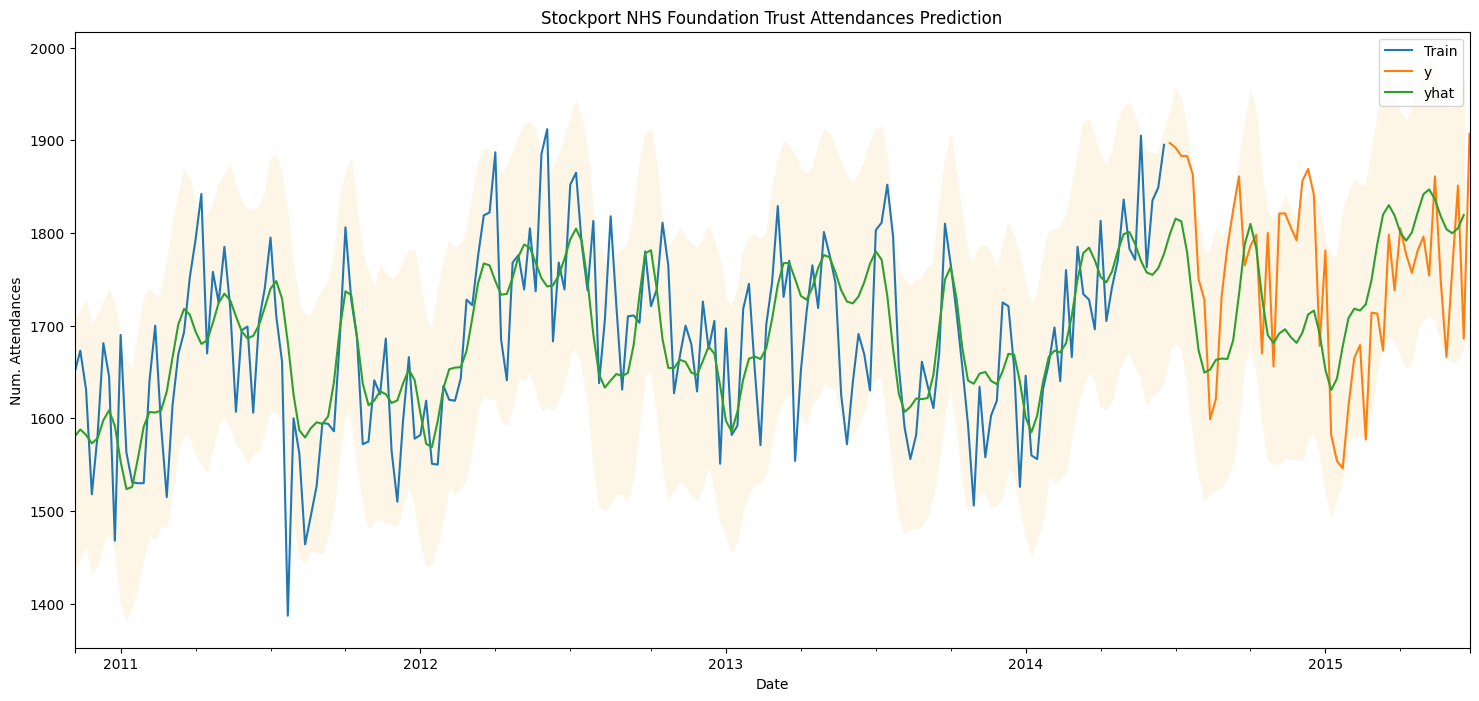

In [480]:
import matplotlib
import matplotlib.pyplot as plt
ts = merge_df.query(f'Name == "{filter_name}"')
matplotlib.rcParams['figure.figsize'] = (18, 8)
ts[['Train', 'y', 'yhat']].plot()
plt.fill_between(ts.index, ts['yhat_lower'], ts['yhat_upper'], color='oldlace')
plt.title(filter_name+ ' Attendances Prediction')
plt.xlabel('Date')
plt.ylabel('Num. Attendances')
plt.show()

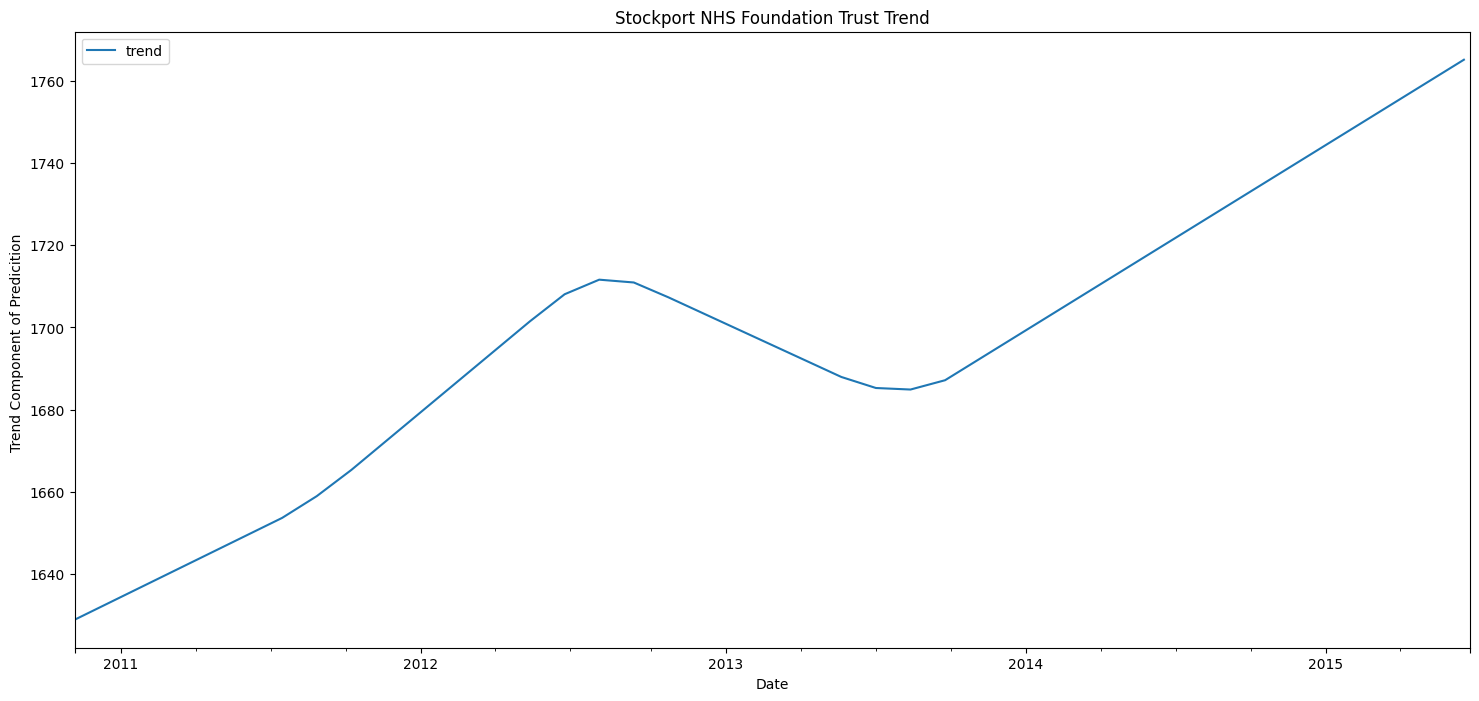

In [481]:
trend = merge_df.query(f'Name == "{filter_name}"')
matplotlib.rcParams['figure.figsize'] = (18, 8)
trend[['trend']].plot()
plt.title(filter_name + ' Trend')
plt.xlabel('Date')
plt.ylabel('Trend Component of Predicition ')
plt.show()

In [482]:
# monthly = merge_df.query(f'Name == "{filter_name}"')
# matplotlib.rcParams['figure.figsize'] = (18, 8)
# monthly[['monthly']].plot()
# plt.show()

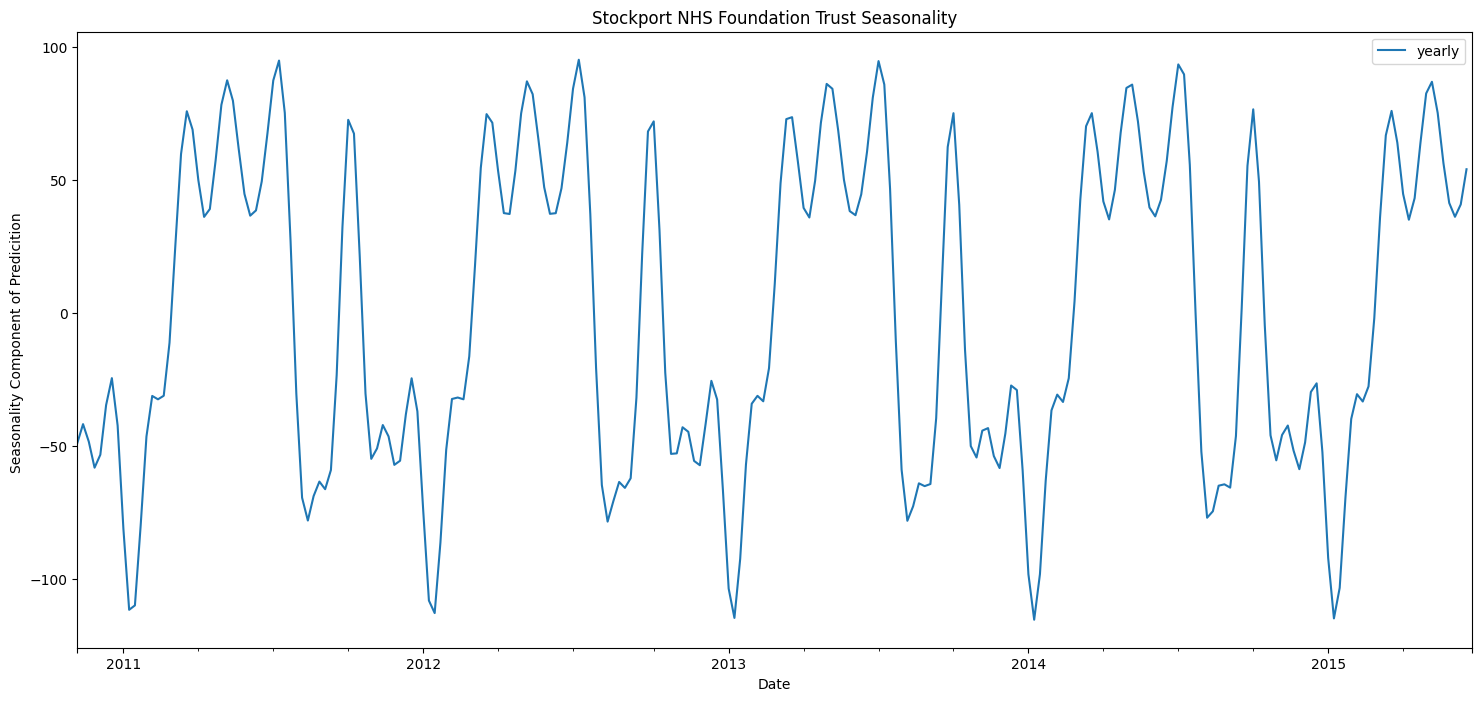

In [483]:
yearly = merge_df.query(f'Name == "{filter_name}"')
matplotlib.rcParams['figure.figsize'] = (18, 8)
#yearly = yearly.loc['2011-1-1':'2012-1-1']
yearly[['yearly']].plot()
plt.title(filter_name + ' Seasonality')
plt.xlabel('Date')
plt.ylabel('Seasonality Component of Predicition ')
plt.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/group_ops.py:103: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


0.07704806327819824


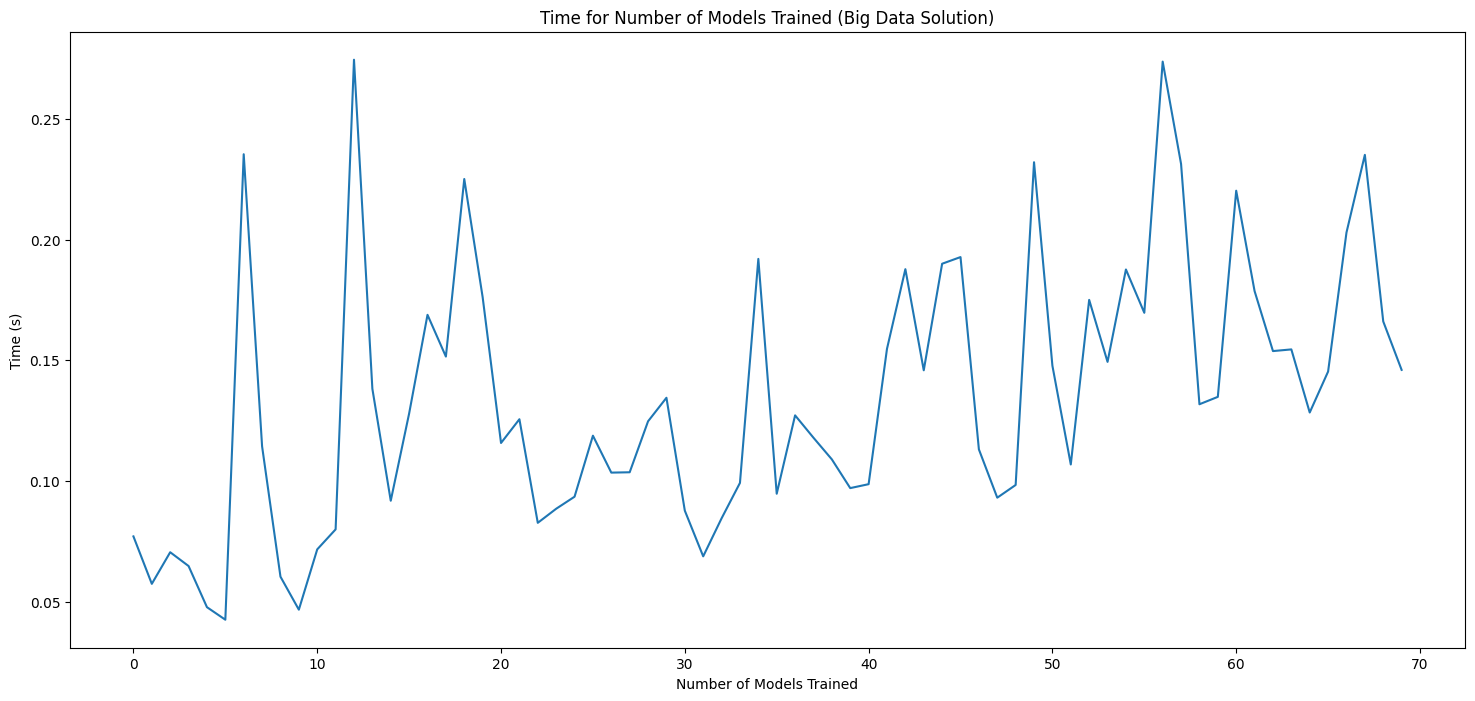

In [484]:
import time

attend_part.select('Name').distinct().collect()
array = [row.Name for row in attend_part.select('Name').distinct().collect()]
times = []
iter = len(attend_part.select('Name').distinct().collect())
for i in range(iter):
    start_time = time.time()
    attend_part.filter(attend_part.Name.isin(array[0:i])).groupby('Name').apply(forecast)
    end_time = time.time()
    times.append(end_time - start_time)
plt.plot(times)
print(times[0])
# x_values = [0, iter]
# y_values = [times[0] , times[0]*iter ]
# plt.plot(x_values, y_values)
plt.title('Time for Number of Models Trained (Big Data Solution)')
plt.xlabel('Number of Models Trained')
plt.ylabel('Time (s)')
plt.show()




In [485]:
final_eval = results.toPandas()
final_eval = final_eval.rename(columns={'y':'Train'})
merge_df = final_eval.merge( attend_test_pd, how = 'outer', on= ['Name', 'ds'])
merge_df = merge_df.set_index('ds')

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [486]:
eval = merge_df[['Name', 'y', 'yhat']].dropna()
eval = eval[eval['y'] != 0]
eval[['y', 'yhat']]

y         yhat
ds                             
2014-06-29  1502.0  1594.888105
2014-07-06  1615.0  1593.232250
2014-07-13  1591.0  1599.270244
2014-07-20  1669.0  1607.953529
2014-07-27  1597.0  1603.414261
...            ...          ...
2015-05-24   841.0   914.255446
2015-05-31   854.0   910.383958
2015-06-07   866.0   912.702614
2015-06-14   940.0   920.627202
2015-06-21   935.0   925.112362

[3640 rows x 2 columns]

In [487]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_true=eval['y'], y_pred=eval['yhat']))

170.28478128681576

In [488]:
def mape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    return np.mean(np.abs((y - yhat) / y)) * 100

In [489]:
mape(eval['y'],eval['yhat'])

5.550579441781054